# 贝叶斯统计实战

下面我们进入本文的主题，贝叶斯的实战这里我们使用了两个PyMC3和 ArviZ这两个库，其中PyMC3是一个语法非常简单的用于概率编程的python库，而ArviZ则可以帮我们解释和可视化后验分布。这里我们将贝叶斯方法运用在一个实际问题上，你将会看到我是如何定义先验概率，如何创建概率模型，如何计算后验概率分布。

## 实现贝叶斯方法的一般步骤

* 1.了解数据，建立先验和似然
* 2.利用先验和似然在原始数据的基础上更新模型，得到后验概率分布
* 3.使用后验概率更新先前的先验概率，循环迭代执行第2步骤，直至后验概率趋于收敛。

## 数据

我们的数据来自于西班牙的高铁票价定价数据集，你可以在这里下载（https://www.kaggle.com/thegurusteam/spanish-high-speed-rail-system-ticket-pricing.

In [1]:
from scipy import stats
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import seaborn as sns
import pandas as pd
from theano import shared
from sklearn import preprocessing

print('Running on PyMC3 v{}'.format(pm.__version__))

/home/zheming2009/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/home/zheming2009/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Running on PyMC3 v3.7


In [41]:
df = pd.read_csv('./data/renfe.csv')
df.drop('Unnamed: 0', axis = 1, inplace=True)
df = df.sample(frac=0.01, random_state=99)
df.head(3)

,insert_date,origin,destination,start_date,end_date,train_type,price,train_class,fare
420104,2019-04-22 08:00:25,MADRID,SEVILLA,2019-04-28 08:30:00,2019-04-28 11:14:00,ALVIA,NaN,Turista,Flexible
431888,2019-04-22 10:03:24,MADRID,VALENCIA,2019-05-20 06:45:00,2019-05-20 08:38:00,AVE,21.95,Turista,Promo
791293,2019-04-25 19:19:46,MADRID,SEVILLA,2019-05-29 06:20:00,2019-05-29 09:16:00,AV City,38.55,Turista,Promo


我们查看一下数据集中各个变量的类型：

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25798 entries, 420104 to 1586358
Data columns (total 9 columns):
insert_date    25798 non-null object
origin         25798 non-null object
destination    25798 non-null object
start_date     25798 non-null object
end_date       25798 non-null object
train_type     25798 non-null object
price          22716 non-null float64
train_class    25695 non-null object
fare           25695 non-null object
dtypes: float64(1), object(8)
memory usage: 2.0+ MB


我们看到start_date和end_date都是字符串类型(object),这是不正确的，我们需要将 start_date和end_date转换成datetime类型。

In [43]:
for i in ['start_date', 'end_date']:
    df[i] = pd.to_datetime(df[i])

下面我们查看数据中是否存在缺失值的情况:

In [44]:
df.isnull().sum()/len(df)

insert_date    0.000000
origin         0.000000
destination    0.000000
start_date     0.000000
end_date       0.000000
train_type     0.000000
price          0.119467
train_class    0.003993
fare           0.003993
dtype: float64

我们看到price、train_class、和fare这三个变量存在缺失值。因此我们需要对缺失值进行填充。方法是对于分类型变量(object)我们用最频繁出现的值(mode)来填充缺失值 , 对于float类型的变量price我们用其对应的票价类型(fare)的均值来填充缺失值:

In [6]:
df['train_class'] = df['train_class'].fillna(df['train_class'].mode().iloc[0])
df['fare'] = df['fare'].fillna(df['fare'].mode().iloc[0])
df['price'] = df.groupby('fare').transform(lambda x: x.fillna(x.mean()))

df.shape

(25798, 9)

## 高斯推断 

票价price是我们的目标变量，这里我们要对price变量进行建模，首先我们要查看price分布，我们使用ArviZ的kde图查看price的分布和密度情况：

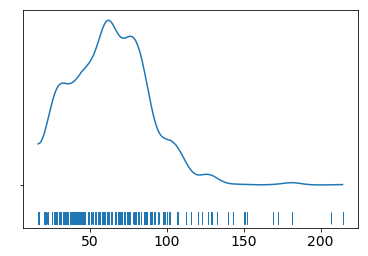

In [7]:
az.plot_kde(df['price'].values, rug=True)
plt.yticks([0], alpha=0);

我们看到price呈现出类似正太分布(高斯分布)的形状，大部分数据集中在0-100这个区间，少量的极端数据的price大于150 .

正太分布有两个参数均值和标准差，假如我们的kde图对price的描述是正确的，那么price中也包含了这和这两个参数。下面我们要做的就是要想办法找出两个参数的值。所使用的方法就是前面所接受的贝叶斯公式，首先我们要设置这两个参数的先验概率分布。

## 模型

In [8]:
with pm.Model() as model_g:
    μ = pm.Uniform('μ', lower=0, upper=300)#设置μ的先验概率服从均匀分布
    σ = pm.HalfNormal('σ', sd=10)#设置σ的先验概率服从半正太分布
    y = pm.Normal('y', mu=μ, sd=σ, observed=df['price'].values) #设置似然y，表示由参数为μ和σ的正态分布所产生的数据。
    trace_g = pm.sample(1000, tune=1000)#抽样1000个后验样本。

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 4000/4000 [00:06<00:00, 647.50draws/s]


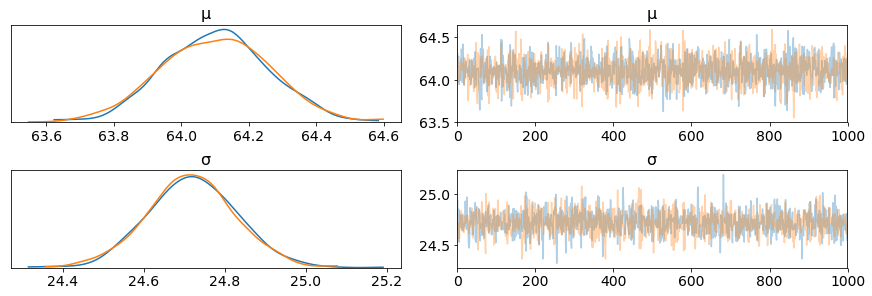

In [9]:
az.plot_trace(trace_g);

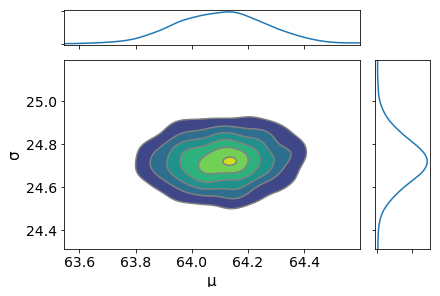

In [10]:
az.plot_joint(trace_g, kind='kde', fill_last=False);

In [11]:
az.summary(trace_g)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,64.102,0.157,63.825,64.402,0.004,0.002,1995.0,1995.0,1996.0,1589.0,1.0
σ,24.719,0.109,24.513,24.920,0.003,0.002,1782.0,1782.0,1800.0,1196.0,1.0


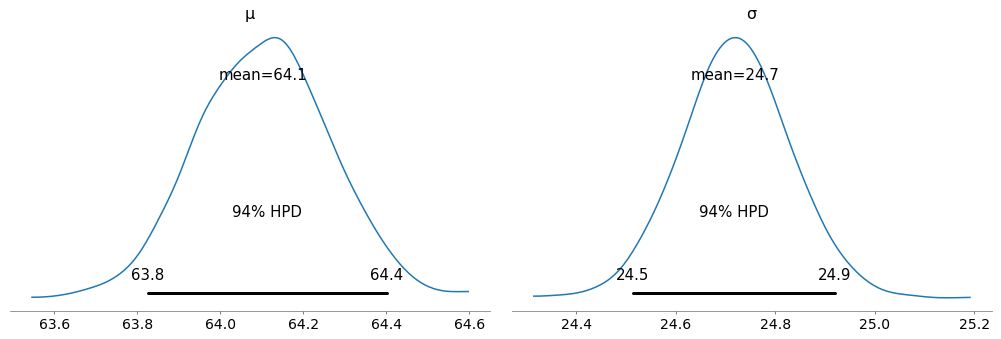

In [12]:
az.plot_posterior(trace_g);

In [13]:
pm.gelman_rubin(trace_g)

{'μ': 0.9995931413099685, 'σ': 1.000252253661437}

计算遗漏信息（BFMI）的估计贝叶斯分数。关于BFMI可以参考这篇论文(https://arxiv.org/pdf/1604.00695.pdf) .如果BFMI的值小于0.2则表示采样不良。 但是，此阈值是临时的，可能会发生变化。如果想更深入了解请看这篇文章(https://mc-stan.org/users/documentation/case-studies/pystan_workflow.html)

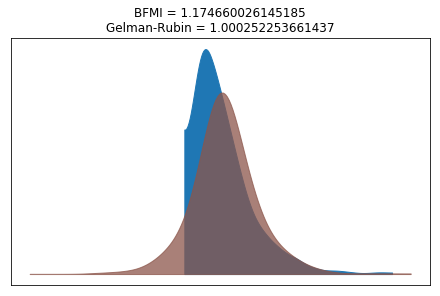

In [14]:
bfmi = pm.bfmi(trace_g)
max_gr = max(np.max(gr_stats) for gr_stats in pm.gelman_rubin(trace_g).values())

(pm.energyplot(trace_g, legend=False, figsize=(6, 4)).set_title("BFMI = {}\nGelman-Rubin = {}".format(bfmi, max_gr)));

In [15]:
ppc = pm.sample_posterior_predictive(trace_g, samples=1000, model=model_g)

np.asarray(ppc['y']).shape

100%|██████████| 1000/1000 [00:02<00:00, 458.50it/s]


(1000, 25798)

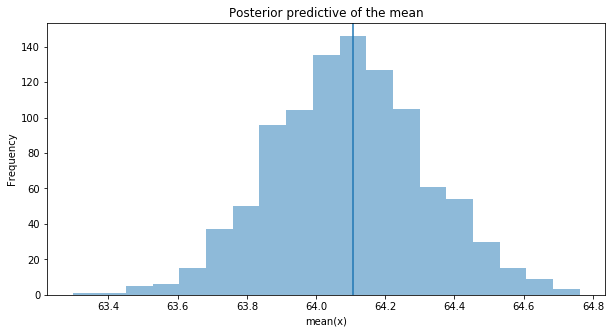

In [16]:
_, ax = plt.subplots(figsize=(10, 5))
ax.hist([y.mean() for y in ppc['y']], bins=19, alpha=0.5)
ax.axvline(df.price.mean())
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency');

## 组间的均值差异比较

我们可能对不同票价类型(fare)的车票价格比较感兴趣。 接下来我们将研究不同票价类型的车票价格之间的差异。 为了比较票价类别，我们要研究一下每种票价类型的均值。 由于我们使用的是贝叶斯模型，我们可以获得票价类别之间均值差异的后验分布。为此我们要创建3个变量

* price，代表车票价格
* idx，表示经过编码后的票价类型(fare)
* groups,表示6个不同的票价类型(fare)。


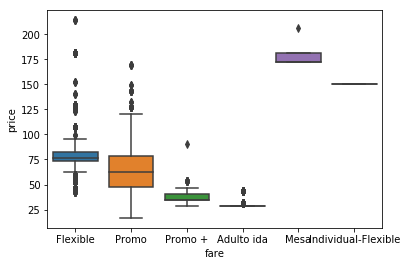

In [17]:
sns.boxplot(x='fare', y='price', data=df);

In [18]:
df.fare.unique()

array(['Flexible', 'Promo', 'Promo +', 'Adulto ida', 'Mesa',
       'Individual-Flexible'], dtype=object)

In [19]:
price = df['price'].values
idx = pd.Categorical(df['fare'],
                     categories=['Flexible', 'Promo', 'Promo +', 'Adulto ida', 'Mesa', 'Individual-Flexible']).codes
groups = len(np.unique(idx))

In [20]:
idx[:10]

array([0, 1, 1, 2, 1, 1, 1, 1, 3, 0], dtype=int8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, μ]
Sampling 2 chains: 100%|██████████| 20000/20000 [04:59<00:00, 66.70draws/s] 


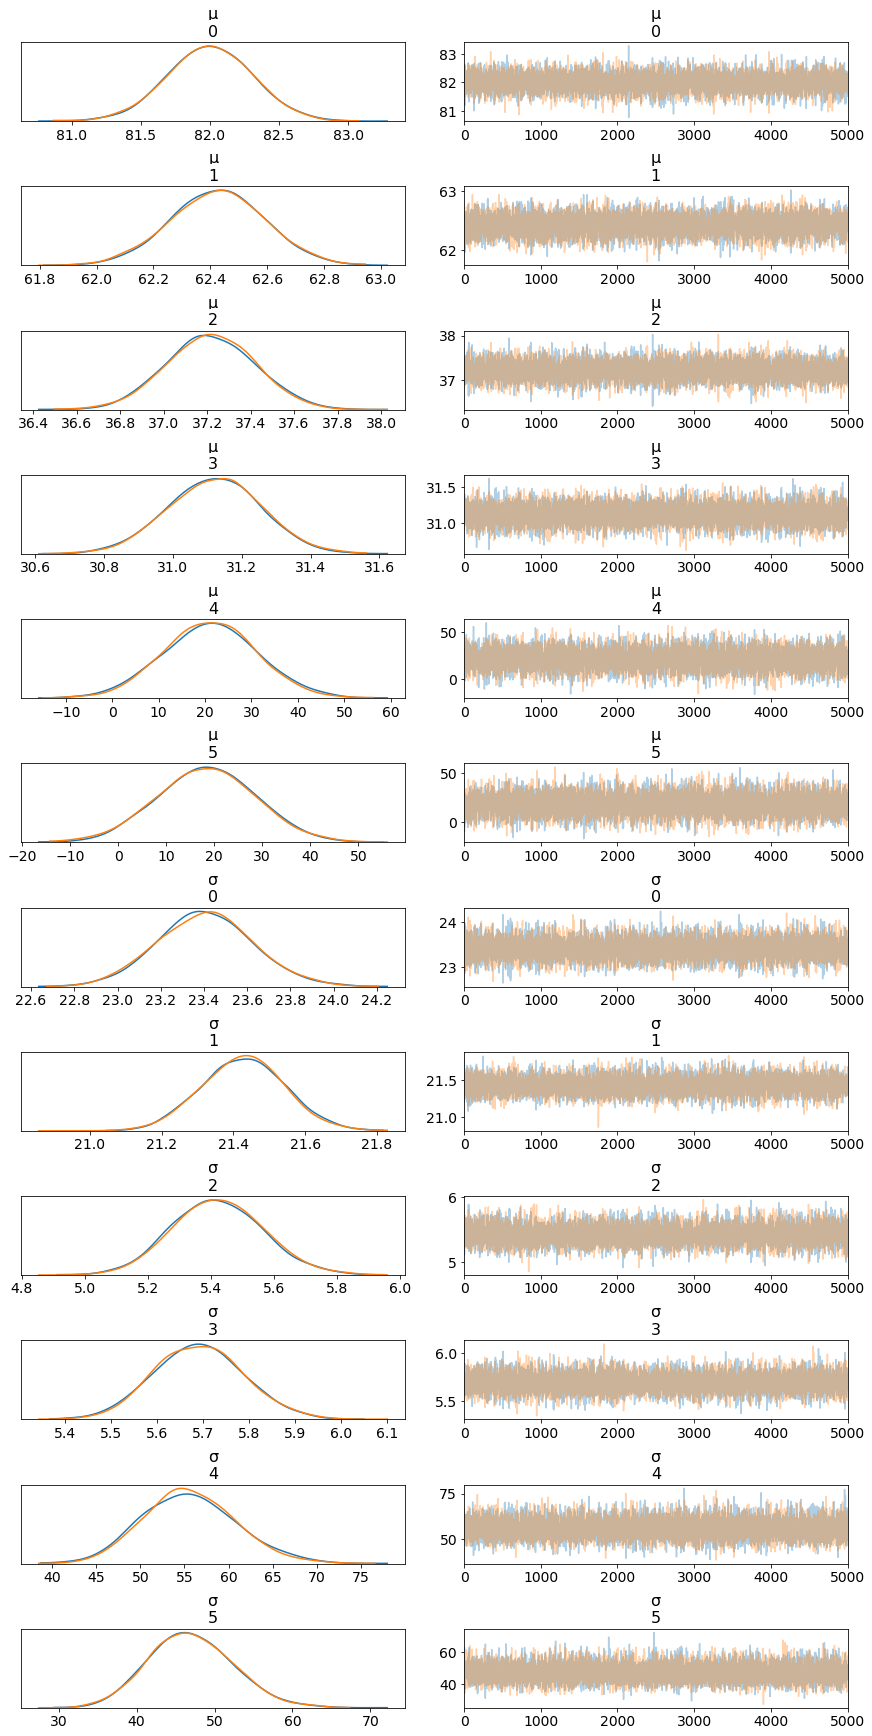

In [22]:
with pm.Model() as comparing_groups:
    μ = pm.Normal('μ', mu=0, sd=10, shape=groups) #设置μ的初始先验分布为正太分布
    σ = pm.HalfNormal('σ', sd=10, shape=groups) #设置σ的初始先验分布为正太分布

    y = pm.Normal('y', mu=μ[idx], sd=σ[idx], observed=price) #设置似然变量y

    trace_groups = pm.sample(5000, tune=5000)
az.plot_trace(trace_groups);

In [23]:
flat_fares = az.from_pymc3(trace=trace_groups)
fares_gaussian = az.summary(flat_fares)
fares_gaussian

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ[0],82.000,0.303,81.413,82.559,0.003,0.002,11675.0,11675.0,11713.0,6969.0,1.0
μ[1],62.426,0.164,62.113,62.736,0.001,0.001,12198.0,12197.0,12192.0,7775.0,1.0
μ[2],37.218,0.201,36.850,37.602,0.002,0.001,11271.0,11271.0,11280.0,6824.0,1.0
μ[3],31.121,0.135,30.873,31.377,0.001,0.001,12749.0,12748.0,12759.0,7521.0,1.0
μ[4],21.145,10.042,1.585,39.215,0.091,0.068,12051.0,10767.0,12034.0,8291.0,1.0
μ[5],18.497,10.152,-0.248,37.492,0.092,0.070,12160.0,10443.0,12155.0,8544.0,1.0
σ[0],23.408,0.218,22.985,23.813,0.002,0.001,11380.0,11370.0,11425.0,6827.0,1.0
σ[1],21.427,0.114,21.207,21.633,0.001,0.001,12443.0,12442.0,12433.0,7306.0,1.0
σ[2],5.422,0.143,5.162,5.698,0.001,0.001,11693.0,11693.0,11673.0,7468.0,1.0
σ[3],5.691,0.096,5.516,5.876,0.001,0.001,12472.0,12472.0,12461.0,6670.0,1.0


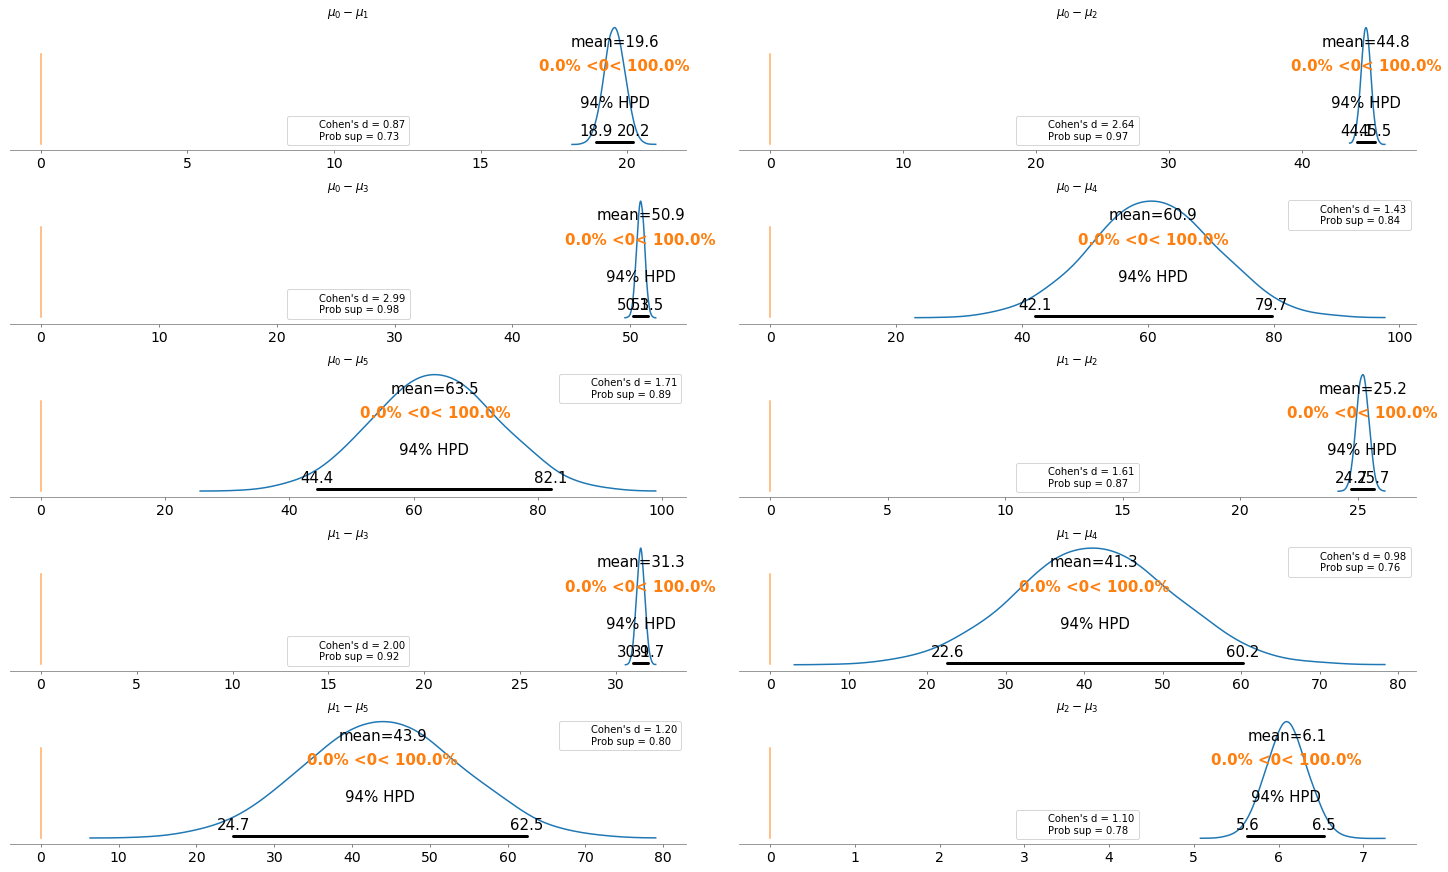

In [24]:
dist = stats.norm()

_, ax = plt.subplots(5, 2, figsize=(20, 12), constrained_layout=True)

comparisons = [(i, j) for i in range(6) for j in range(i+1, 6)]
pos = [(k, l) for k in range(5) for l in (0, 1)]

for (i, j), (k, l) in zip(comparisons, pos):
    means_diff = trace_groups['μ'][:, i] - trace_groups['μ'][:, j]
    d_cohen = (means_diff / np.sqrt((trace_groups['σ'][:, i]**2 + trace_groups['σ'][:, j]**2) / 2)).mean()
    ps = dist.cdf(d_cohen/(2**0.5))
    az.plot_posterior(means_diff, ref_val=0, ax=ax[k, l])
    ax[k, l].set_title(f'$\mu_{i}-\mu_{j}$')
    ax[k, l].plot(
        0, label=f"Cohen's d = {d_cohen:.2f}\nProb sup = {ps:.2f}", alpha=0)
    ax[k, l].legend();

## 贝叶斯分层线性回归

我们想建立一个模型来估算每种票价类型的铁路车票价格，同时估算所有票价类型的价格。 这种类型的模型称为分层模型或多级模型。首先我们要对分类型变量车票类型(fare)以及火车类型(train_type)进行编码,因为我们认为除了车票类型(fare)之外，火车类型(train_type)也可能对price产生影响。因此我们的模型中也需要加入火车类型(train_type)这个变量。

In [25]:
def replace_fare(fare):
    
    if fare == 'Adulto ida':
        return 1
    elif fare == 'Promo +':
        return 2
    elif fare == 'Promo':
        return 3
    elif fare == 'Flexible':
        return 4
    elif fare == 'Individual-Flexible':
        return 5
    elif fare == 'Mesa':
        return 6

df['fare_encode'] = df['fare'].apply(lambda x: replace_fare(x))

label_encoder = preprocessing.LabelEncoder() 
df['train_type_encode']= label_encoder.fit_transform(df['train_type'])

train_type_names = df.train_type.unique()
train_type_idx = df.train_type_encode.values

n_train_types = len(df.train_type.unique())

df[['train_type', 'price', 'fare_encode']].head()

,train_type,price,fare_encode
420104,ALVIA,82.077189,4
431888,AVE,21.950000,3
791293,AV City,38.550000,3
678876,LD-MD,34.350000,2
86381,AVE,45.300000,3


In [39]:
df.groupby("train_type_encode").price.mean()

train_type_encode
0     63.370095
1     51.539084
2     70.280890
3     51.635435
4     59.382847
5     83.377986
6     45.881980
7     52.931657
8     68.333247
9     46.883394
10    57.942821
11    48.035526
12    41.902708
13    42.913256
14    28.438010
15    50.015111
Name: price, dtype: float64

In [38]:
df.groupby("fare_encode").price.mean()

fare_encode
1     31.127219
2     37.233383
3     62.442987
4     82.077189
5    150.600000
6    181.000000
Name: price, dtype: float64

## 分层模型

In [26]:
with pm.Model() as hierarchical_model:
    # 指定初始的模型参数的先验概率分布
    α_μ_tmp = pm.Normal('α_μ_tmp', mu=0., sd=100)
    α_σ_tmp = pm.HalfNormal('α_σ_tmp', 5.)
    β_μ = pm.Normal('β_μ', mu=0., sd=100)
    β_σ = pm.HalfNormal('β_σ', 5.)

    # 列车类型特定的模型参数
    α_tmp = pm.Normal('α_tmp', mu=α_μ_tmp, sd=α_σ_tmp, shape=n_train_types)  
    β = pm.Normal('β', mu=β_μ, sd=β_σ, shape=n_train_types)
    # 模型误差先验,半柯西分布
    eps = pm.HalfCauchy('eps', 5.)

    #模型定义
    fare_est = α_tmp[train_type_idx] + β[train_type_idx]*df.fare_encode.values

    # 数据似然
    fare_like = pm.Normal('fare_like', mu=fare_est, sd=eps, observed=df.price)
    
    hierarchical_trace = pm.sample(2000, tune=2000, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [eps, β, α_tmp, β_σ, β_μ, α_σ_tmp, α_μ_tmp]
Sampling 2 chains: 100%|██████████| 8000/8000 [10:23<00:00,  7.32draws/s] 


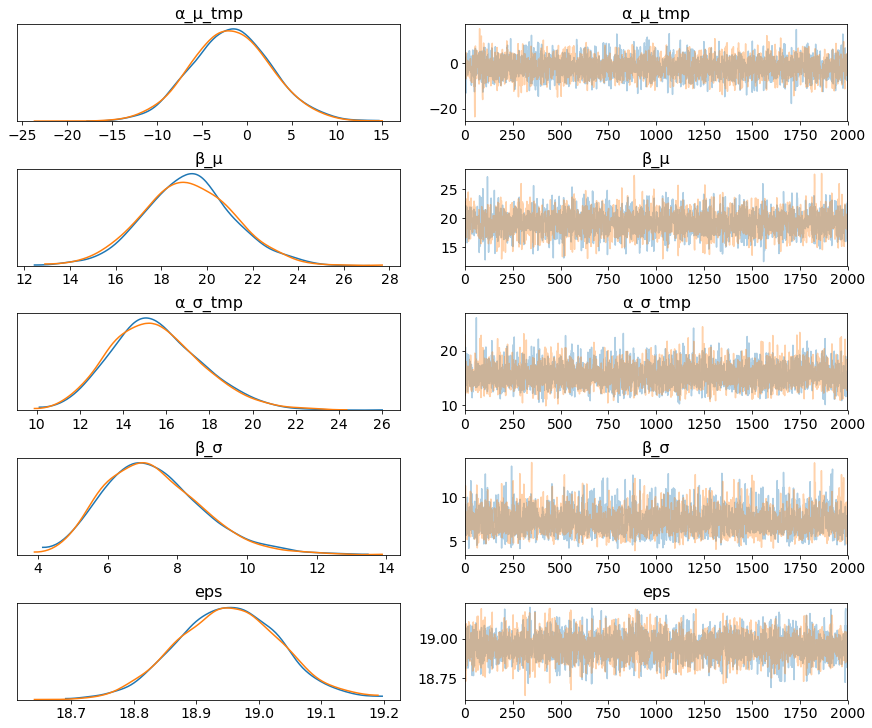

In [27]:
pm.traceplot(hierarchical_trace, var_names=['α_μ_tmp', 'β_μ', 'α_σ_tmp', 'β_σ', 'eps']);  

上图中左边一列中α_μ_tmp表示火车类型(train_type)权重均值分布，β_μ表示各个不同票价类型(fare)的价格变化的分布。由于火车类型(train_type)有16种，我们查看前5种火车类型在模型中的权重分布


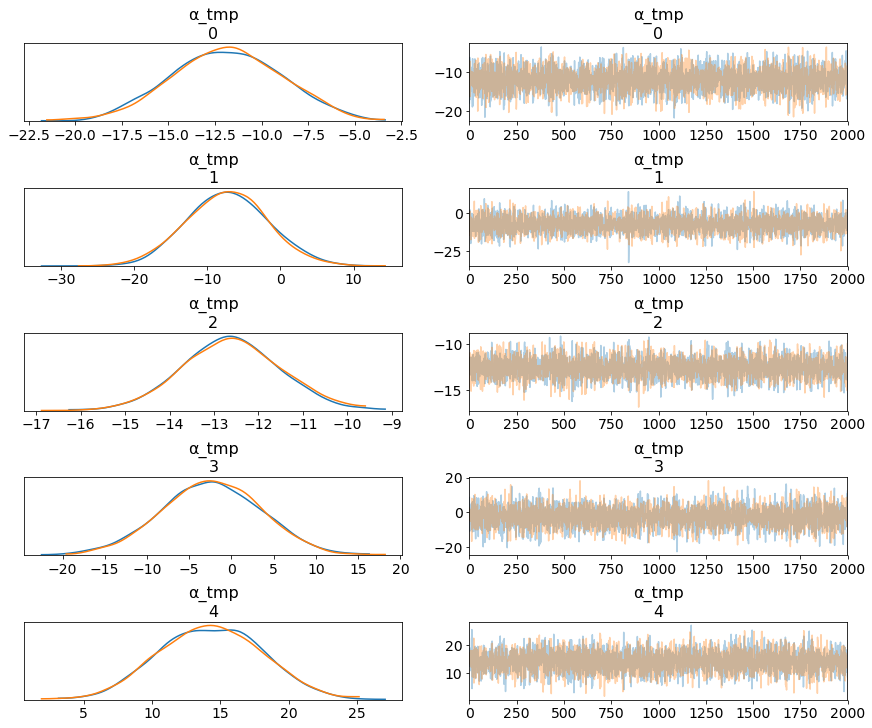

In [28]:
pm.traceplot(hierarchical_trace, var_names=['α_tmp'], coords={'α_tmp_dim_0': range(5)});

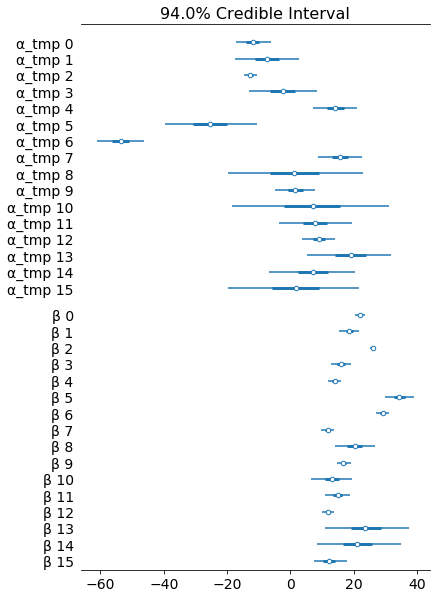

In [29]:
az.plot_forest(hierarchical_trace, var_names=['α_tmp', 'β'], combined=True);

In [30]:
ppc = pm.sample_posterior_predictive(hierarchical_trace, samples=2000, model=hierarchical_model)
az.r2_score(df.price.values, ppc['fare_like'])

100%|██████████| 2000/2000 [00:05<00:00, 341.51it/s]


r2        0.412068
r2_std    0.007676
dtype: float64